<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исходные-данные" data-toc-modified-id="Исходные-данные-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исходные данные</a></span></li><li><span><a href="#План-проекта" data-toc-modified-id="План-проекта-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>План проекта</a></span></li><li><span><a href="#Установка-и-импорт-библиотек" data-toc-modified-id="Установка-и-импорт-библиотек-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Установка и импорт библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Поиск-дубликатов" data-toc-modified-id="Поиск-дубликатов-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Поиск дубликатов</a></span></li><li><span><a href="#Распределение-параметров" data-toc-modified-id="Распределение-параметров-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Распределение параметров</a></span></li><li><span><a href="#Проверка-на-мультиколлинеарность" data-toc-modified-id="Проверка-на-мультиколлинеарность-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Проверка на мультиколлинеарность</a></span></li></ul></li><li><span><a href="#Исследование-кластеризации" data-toc-modified-id="Исследование-кластеризации-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Исследование кластеризации</a></span><ul class="toc-item"><li><span><a href="#Метод-K-Means-и-Mini-batch-K-Means" data-toc-modified-id="Метод-K-Means-и-Mini-batch-K-Means-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Метод K-Means и Mini-batch K-Means</a></span></li><li><span><a href="#Метод-DBSCAN" data-toc-modified-id="Метод-DBSCAN-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Метод DBSCAN</a></span></li><li><span><a href="#Иерархическая-кластеризация" data-toc-modified-id="Иерархическая-кластеризация-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Иерархическая кластеризация</a></span></li><li><span><a href="#Выбор-метода-кластеризации" data-toc-modified-id="Выбор-метода-кластеризации-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Выбор метода кластеризации</a></span></li></ul></li><li><span><a href="#Поиск-соответствий" data-toc-modified-id="Поиск-соответствий-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Поиск соответствий</a></span><ul class="toc-item"><li><span><a href="#Поиск-соответствий-на-малом-датафрейме-с-помощью-FAISS" data-toc-modified-id="Поиск-соответствий-на-малом-датафрейме-с-помощью-FAISS-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Поиск соответствий на малом датафрейме с помощью FAISS</a></span></li></ul></li></ul></div>

ФИО автора работы: Богуто Елена Александровна   

telegram: @BelkaBoguto   

e-mail: slush1ster@gmail.com

# Мастерская 2 - DS+: Мэтчинг товаров

## Исходные данные

Обучающий датасет, валидационный датасет и base (датасет со всеми товарами) содержат индексы товаров из base, обезличенные признаки товаров и “правильные ответы” - индексы наиболее подходящих товаров-аналогов (кроме валидационного датасета - для него “правильные ответы” содержатся в отдельном файле). Данные достаточно объемные (более 2 Гб). Также существует уменьшенная (~10% от исходной) версия датасета.

В качестве метрики используется accuracy@n.
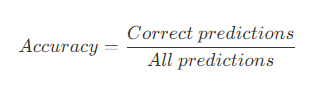
"Представим расчет метрики в цикле, перебирая все предложенные моделью ответы. При этом каждое предсказание содержит в себе не 1 ответ, а сразу n, и если среди предложенных вариантов окажется правильный - числитель и знаменатель увеличиваются на 1. А если нет ни одного - то на 1 увеличивается только знаменатель. В нашей задаче n = 5. Хорошо бы добиться accuracy@5 ≥ 0,7."

## План проекта

1. Загрузить данные (воспользовавшись способом из обучающего примера, т.к. данные большие)
2. Провести исследовательский анализ
3. Изучить данные с помощью FAISS
4. Разработать ранжирующую модель
5. Написать вывод

## Установка и импорт библиотек

In [1]:
!pip install --upgrade scikit-learn -q

In [2]:
!pip install faiss-cpu -q

In [41]:
import numpy as np
import pandas as pd
import sklearn
import faiss
import requests
import os
import zipfile
import io
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import os.path

from tqdm.notebook import tqdm
from urllib.parse import urlencode
from zipfile import ZipFile

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [4]:
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 75)

## Загрузка данных

In [5]:
#def downloader(size: str='small'):
#    if size not in ['small', 'large']:
#        raise Exception('Unknown Argument')
#    elif size == 'small':
#        public_key = 'https://disk.yandex.ru/d/YQElc_cNQQLSOw'
#    else:
#        public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'

#    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

#    final_url = base_url + urlencode(dict(public_key=public_key))
#    response = requests.get(final_url)
#    download_url = response.json()['href']

#    download_response = requests.get(download_url)

#    Path('content').mkdir(parents=True, exist_ok=True)
#    if not os.path.isfile('content/data.zip'):
#        open('content/data.zip', 'x') 
    
#    with open('content/data.zip', 'wb') as f:
#        f.write(download_response.content)

#    zip_path = ('content/data.zip')

#    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#        zip_ref.extractall()

In [6]:
#downloader('large')

In [7]:
# прочтем большой базовый датафрейм

df_base_large = pd.read_csv("base_large.csv", index_col=0)
df_base_large.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.59631,-38.995880,-4.787360,8.327808,-124.85576,-79.10902,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.93434,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.29577,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.31432,7.912551,-62.18892,-540.321044,-89.588715,-149.32669,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.27290,-7.510103,8.924209,111.576950,-130.83319,-79.31585,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.13185,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.70898,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.78206,77.62

In [8]:
df_base_large.shape

(2918139, 72)

In [9]:
# прочтем большой тренировочный датафрейм

df_train_large = pd.read_csv("train_large.csv", index_col=0)
df_train_large.shape

(100000, 73)

In [10]:
# прочтем большой валидационный датафрейм

df_validation_large = pd.read_csv("validation_large.csv", index_col=0)
df_validation_large.shape

(100000, 72)

In [11]:
# прочтем большой файл с "ответами"

df_validation_answer_large = pd.read_csv("validation_answer_large.csv", index_col=0)
df_validation_answer_large.shape

(100000, 1)

In [12]:
# прочтем малый базовый датафрейм

df_base_small = pd.read_csv("base.csv", index_col=0)
df_base_small.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,45.090958,-126.84374,4.494522,-99.842310,44.926903,177.52173,-12.291790,38.470360,105.357650,-142.46024,-80.163260,-110.368935,1047.517357,-69.594620,66.313540,84.873870,813.770071,-81.038780,16.162964,-98.244880,159.53406,27.554913,-209.184280,62.05977,-529.295053,114.598330,90.469894,-20.256914,-164.76800,-133.31387,-41.252960,-10.251193,8.289038,-131.312710,75.704500,-16.483078,40.771038,-146.096740,-143.407680,49.807987,63.434480,-30.250080,20.470263,78.079910,-128.915310,92.327680,63.885570,-141.17464,142.902590,-93.068596,-568.421584,-90.018690,-129.015670,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
2710972-base,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,201.472200,-186.22650,29.896042,-99.770996,0.126302,136.19049,-35.224740,-30.321323,-43.148834,-162.85175,-79.714510,-75.784870,1507.231274,-69.654564,43.640663,-4.779669,813.770071,43.976913,11.924875,-50.228523,166.00820,-59.505333,-115.332520,72.18324,-735.671365,96.322300,85.796360,-22.030330,-147.54501,-108.38295,-45.084892,-15.004004,-1.532826,-46.456585,197.578950,-56.199876,60.298710,-102.653340,-108.967964,58.512012,-9.678028,-85.448300,-68.686080,71.590200,-232.425690,91.706856,63.290657,-137.33595,-47.124687,-148.057400,-543.787056,-160.651600,-133.462220,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
1371460-base,-85.565570,-0.493598,-48.374817,-157.98502,96.809510,-81.710210,-22.297688,79.768670,124.357086,105.715180,-149.80756,-54.501680,-21.037973,-24.887660,128.38864,-58.558483,34.862656,19.784412,-130.91820,-79.032230,-166.635250,1507.231274,-8.495993,61.205086,25.895348,813.770071,-140.768860,20.872790,-123.957570,126.34781,11.713674,-125.025154,152.68590,-1018.469545,-22.444600,73.897640,9.190645,-156.51881,-92.18573,-34.926760,-13.277475,16.026424,-33.853546,119.604520,-52.525341,71.204750,-178.702940,-88.278500,30.501453,16.651737,-88.377014,-55.883583,70.182980,-89.233925,92.005780,76.458725,-131.14087,40.914352,-157.900540,-394.319235,-87.107025,-120.772545,-58.821650,41.369606,-132.934500,-43.016839,67.871925,141.778240,69.048520,111.72038,-1111.038833,-23.087206
3438601-base,-105.564090,15.393871,-46.223934,-158.11488,79.514114,-48.944480,-93.713010,38.581398,123.397960,110.324326,-161.18800,-68.519790,-0.607330,38.733696,120.74344,-14.109269,28.868027,-29.858810,-94.30395,-79.339810,-138.984270,1507.231274,-131.885380,70.031360,32.736595,813.770071,-62.370860,13.763219,-31.872276,139.55270,9.836465,-150.221130,80.14020,-537.183707,3.091667,129.699330,-63.429424,-169.02724,-119.77007,-28.637785,-8.315162,2.752385,-160.293820,85.086890,-18.251750,90.374054,1.479935,-121.983050,65.852660,8.355225,34.118896,-57.069756,70.461800,-127.905410,94.314280,71.259940,-135.57787,-39.982346,-159.751560,-230.147648,-95.221160,-148.814090,-87.907290,-58.806870,-147.794800,-155.830237,68.974754,21.397510,126.098785,139.73320,-1282.707248,-74.527940
422798-base,-74.638880,11.315012,-40.204174,-161.76430,50.507114,-80.775560,-640.923467,65.225000,122.344940,191.465850,-156.98384,-76.650210,-75.674970,12.624029,145.33752,-35.774258,11.598761,-11.460761,-201.35443,-77.779366,-120.968400,548.736883,19.851685,17.943344,27.063320,813.770071,-85.483780,21.236433,-95.071020,132.61092,13.526038,-160.476840,104.71937,-304.174382,-15.385452,91.418655,-36.474556,-157.43959,-102.83162,-56.782710,-19.969252,-0.598189,-222.228790,33.441666,-56.092110,71.276030,-8.713509,-86.099380,8.488903,-14.959278,86.812996,-29.6

In [13]:
df_base_small.shape

(291813, 72)

In [14]:
# прочтем малый тренировочный датафрейм

df_train_small = pd.read_csv("train.csv", index_col=0)
df_train_small.shape

(9999, 73)

In [15]:
# прочтем малый валидационный датафрейм

df_validation_small = pd.read_csv("validation.csv", index_col=0)
df_validation_small.shape

(10000, 72)

In [16]:
# прочтем малый файл с "ответами

df_validation_answer_small = pd.read_csv("validation_answer.csv", index_col=0)
df_validation_answer_small.shape

(10000, 1)

Какие именно данные нам переданы на изучение:

- файл `base` - анонимизированный набор товаров. Каждый товар представлен как уникальный id (1-base, 2-base и т.д.) и вектор признаков размерностью 72.
- файл `train` - обучающий датасет. Каждая строка - один товар, для которого известен уникальный id (0-query, 1-query и т.д.), вектор признаков и id товара из `base.csv`, который максимально похож на него по мнению экспертов.
- файл `validation` - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из `base.csv`.
- файл `validation_answers` - правильные ответы к файлу `validation`.

Общая задача звучит, как "разработать алгоритм, который для всех товаров из `validation.csv` предложит несколько вариантов наиболее похожих товаров из `base.csv`.

Метрика объявлена ранее - accuracy@5.

Предостален некий baseline, который можно повторить, для первичного понимания работы алгоритма.

## Исследовательский анализ данных

In [17]:
# посмотрим общий вид данных большого файла

df_base_large.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,-1.431396e+02,-6.988662e+01,-4.126493e+01,7.587780e+00,1.489852e+02,-2.316701e+01,-9.366916e-01,-1.931312e+01,-1.372712e+02,-7.918932e+01,-9.825383e+01,1.257528e+03,-6.824936e+00,5.667382e+01,2.669563e+01,7.271026e+02,-6.625340e+01,1.631537e+01,-8.637482e+01,1.517346e+02,-1.160764e+01,-1.442328e+02,8.721997e+01,-5.541608e+02,3.623933e+01,7.519918e+01,-1.648670e+01,-1.466421e+02,-1.185122e+02,-4.187896e+01,-9.482269e+00,4.050654e+00,-1.127440e+02,1.208653e+02,-3.980939e+01,5.893878e+01,-8.488885e+01,-1.384695e+02,4.792759e+01,-3.238229e+01,2.658408e+01,-2.171709e+01,6.699684e+01,-1.178976e+02,8.802818e+01,6.920454e+01,-1.329056e+02,1.322645e+01,-1.195996e+02,-3.160935e+02,-6.494332e+01,-1.306677e+02,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,4.168737e+01,5.121991e+01,3.896358e+01,3.659725e+01,3.363559e+01,1.307563e+01,2.083201e+01,5.297210e+01,4.662566e+01,7.574403e-01,2.815861e+01,3.999612e+02,5.197251e+01,3.436061e+01,3.894157e+01,2.055724e+02,6.153334e+01,4.656628e+00,4.851313e+01,1.009000e+01,2.895059e+01,3.475739e+01,2.785556e+01,2.606486e+02,3.989506e+01,2.144713e+01,2.585462e+01,9.953913e+00,1.314411e+01,1.919689e+01,8.190720e+00,5.835750e+00,5.694050e+01,4.671995e+01,1.474482e+01,3.211030e+01,6.319335e+01,5.773822e+01,4.520157e+01,5.828693e+01,5.895291e+01,5.173898e+01,1.307173e+01,5.470584e+01,4.774309e+00,1.194907e+01,7.815245e+00,5.107988e+01,5.524317e+01,2.106644e+02,6.248236e+01,9.569063e+00,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,-3.438436e+02,-3.684526e+02,-2.260906e+02,-1.756239e+02,-1.526698e+01,-8.591711e+01,-9.636816e+01,-2.725656e+02,-3.517478e+02,-8.315235e+01,-2.437279e+02,1.368182e+02,-2.382874e+02,-8.818329e+01,-1.431833e+02,-6.198046e+01,-3.585515e+02,-8.364693e+00,-3.140082e+02,1.074433e+02,-1.567305e+02,-2.986792e+02,-3.465488e+01,-1.045312e+03,-1.378509e+02,-2.151936e+01,-1.379866e+02,-1.954172e+02,-1.769110e+02,-1.327073e+02,-4.757769e+01,-2.158085e+01,-3.381192e+02,-8.770834e+01,-6.310310e+01,-7.724959e+01,-3.629306e+02,-4.186953e+02,-1.453876e+02,-3.228121e+02,-2.802731e+02,-2.646334e+02,6.196133e+00,-3.812643e+02,6.558115e+01,1.408166e+01,-1.670627e+02,-1.961836e+02,-3.597054e+02,-6.810424e+02,-4.007911e+02,-1.713491e+02,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.95094

In [18]:
df_base_large.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


In [19]:
df_base_large.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    0
59    0
60    0
61    0
62    0
63    0
64    0
65    0
66    0
67    0
68    0
69    0
70    0
71    0
dtype: int64

Пропусков в данных нет. Все колонки, кроме индекса, численные.

Проверим, что с остальными данными - аналогичная картина.

In [20]:
df_train_large.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

In [21]:
df_validation_large.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

In [22]:
df_base_small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291813 entries, 4207931-base to 274130-base
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       291813 non-null  float64
 1   1       291813 non-null  float64
 2   2       291813 non-null  float64
 3   3       291813 non-null  float64
 4   4       291813 non-null  float64
 5   5       291813 non-null  float64
 6   6       291813 non-null  float64
 7   7       291813 non-null  float64
 8   8       291813 non-null  float64
 9   9       291813 non-null  float64
 10  10      291813 non-null  float64
 11  11      291813 non-null  float64
 12  12      291813 non-null  float64
 13  13      291813 non-null  float64
 14  14      291813 non-null  float64
 15  15      291813 non-null  float64
 16  16      291813 non-null  float64
 17  17      291813 non-null  float64
 18  18      291813 non-null  float64
 19  19      291813 non-null  float64
 20  20      291813 non-null  float64
 21 

In [23]:
df_train_small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 109249-query to 13504-query
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9999 non-null   float64
 1   1       9999 non-null   float64
 2   2       9999 non-null   float64
 3   3       9999 non-null   float64
 4   4       9999 non-null   float64
 5   5       9999 non-null   float64
 6   6       9999 non-null   float64
 7   7       9999 non-null   float64
 8   8       9999 non-null   float64
 9   9       9999 non-null   float64
 10  10      9999 non-null   float64
 11  11      9999 non-null   float64
 12  12      9999 non-null   float64
 13  13      9999 non-null   float64
 14  14      9999 non-null   float64
 15  15      9999 non-null   float64
 16  16      9999 non-null   float64
 17  17      9999 non-null   float64
 18  18      9999 non-null   float64
 19  19      9999 non-null   float64
 20  20      9999 non-null   float64
 21  21      9999 non-null   

In [24]:
df_validation_small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10000 non-null  float64
 1   1       10000 non-null  float64
 2   2       10000 non-null  float64
 3   3       10000 non-null  float64
 4   4       10000 non-null  float64
 5   5       10000 non-null  float64
 6   6       10000 non-null  float64
 7   7       10000 non-null  float64
 8   8       10000 non-null  float64
 9   9       10000 non-null  float64
 10  10      10000 non-null  float64
 11  11      10000 non-null  float64
 12  12      10000 non-null  float64
 13  13      10000 non-null  float64
 14  14      10000 non-null  float64
 15  15      10000 non-null  float64
 16  16      10000 non-null  float64
 17  17      10000 non-null  float64
 18  18      10000 non-null  float64
 19  19      10000 non-null  float64
 20  20      10000 non-null  float64
 21  21      10000 non-null 

### Поиск дубликатов

In [25]:
# проверим на полные дубликаты

df_base_large.duplicated().sum()

0

In [26]:
# проверим на полные дубликаты тренировочный большой файл

df_train_large.duplicated().sum()

0

In [27]:
# проверим на полные дубликаты валидационный большой файл

df_validation_large.duplicated().sum()

0

In [28]:
# проверим на полные дубликаты большой файл с "ответами"

df_validation_answer_large.duplicated().sum()

8498

In [29]:
# проверим на полные дубликаты малый общий файл

df_base_small.duplicated().sum()

11278

In [30]:
# проверим на полные дубликаты малый тренировочный файл

df_train_small.duplicated().sum()

243

In [31]:
# проверим на полные дубликаты валидационный большой файл

df_validation_small.duplicated().sum()

265

In [32]:
# проверим на полные дубликаты малый файл с "ответами"

df_validation_answer_small.duplicated().sum()

360

Получается, у нас есть дубликаты строк вплоть до значений индекса в малой выборке. Проверим это.

In [33]:
# посчитаем количество уникальных индексов

df_base_small.index.nunique()

280535

Все верно: в датафрейме 291813 строк, из которых 280535 строк уникальны, а 11278 строк повторяют существующие. От таких повторов нужно избавляться.

Что касается повторов в "ответах" - это повторы в колонке "Аналогичного товара". По-моему, это нормально, что разным товарам из валидационной выборки оказались наиболее близки одни и те же товары из базовой выборки. Отсюда и дубликаты.

In [34]:
# количество индексов - т.е. уникальных товаров для сравнения

df_validation_answer_large.index.nunique()

100000

In [35]:
# количество аналогичных сопоставленных товаров

df_validation_answer_large.nunique()

Expected    91502
dtype: int64

Убираем дубликаты в малых датафреймах, кроме датафреймов с валидационной выборкой и "ответами". Полагаю, для расчетов нам будет важна их размерность.

In [36]:
df_base_small = df_base_small.drop_duplicates()
df_base_small.shape

(280535, 72)

In [37]:
df_train_small = df_train_small.drop_duplicates()
df_train_small.shape

(9756, 73)

### Распределение параметров

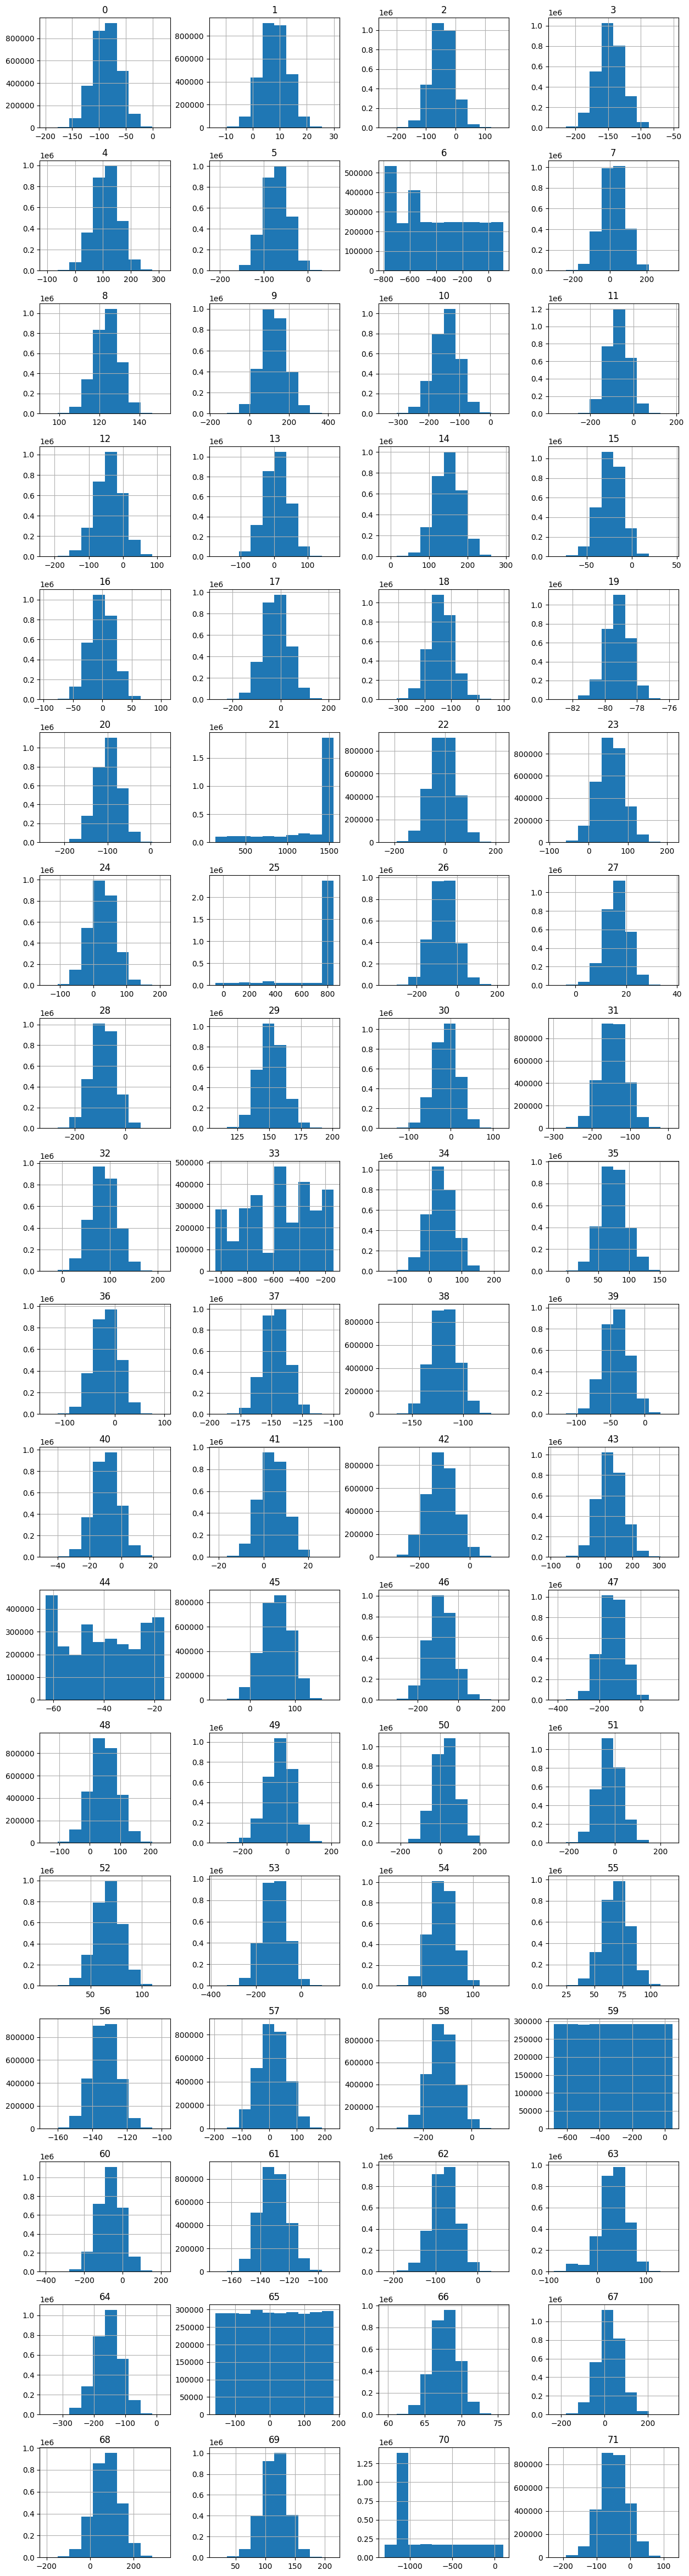

In [76]:
# построим распределение для всех параметров

fig2, axes = plt.subplots(nrows=18, ncols=4, figsize=(15,60))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i, ax in enumerate(axes.flatten()):
    df_base_large[df_base_large.columns[i]].hist(ax=ax)
    ax.set_title(df_base_large.columns[i])

Можно видеть, что часть признаков распределена необычно.    
Так, например, распрелеление признаков 6, 21, 25, 33, 44, 59, 65, 70 визуально отличается от распределения остальных параметров.   
Признаки 21, 25, 59, 65 и 70 можно попробовать удалить из данных.

In [78]:
# создадим датафреймы без "подозрительных" параметров

base_large = df_base_large.drop(columns=['21', '25', '59', '65', '70'])
base_large.shape

(2918139, 67)

In [79]:
train_large = df_train_large.drop(columns=['21', '25', '59', '65', '70'])
validation_large = df_validation_large.drop(columns=['21', '25', '59', '65', '70'])

base_small = df_base_small.drop(columns=['21', '25', '59', '65', '70'])
train_small = df_train_small.drop(columns=['21', '25', '59', '65', '70'])
validation_small = df_validation_small.drop(columns=['21', '25', '59', '65', '70'])

Оставляем в данных 67 признаков вместо 72.

Скалировать данные нет особого смысла - значения всех параметров сосредоточены в областях 10^2-10^3. Это близкие значения.

### Проверка на мультиколлинеарность

In [38]:
#
#import seaborn as sns
#import matplotlib.pyplot as plt

#plt.rcParams['figure.figsize'] = [12, 8]

#sns.heatmap(df_base_small.corr(), cbar=True, cmap= 'coolwarm')

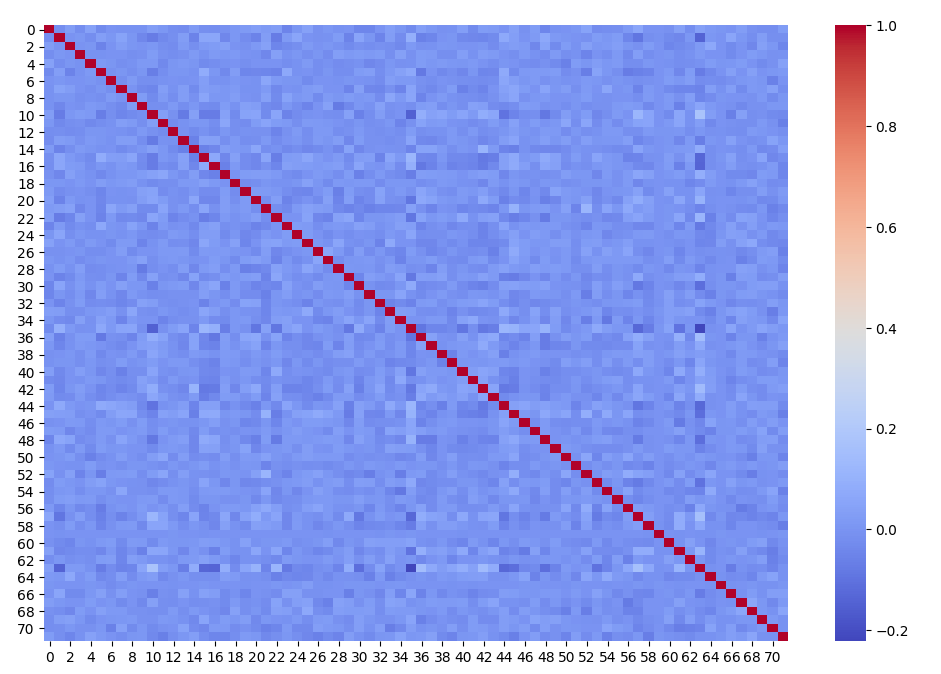

In [39]:
#sns.heatmap(df_base_large.corr(), cbar=True, cmap= 'coolwarm')

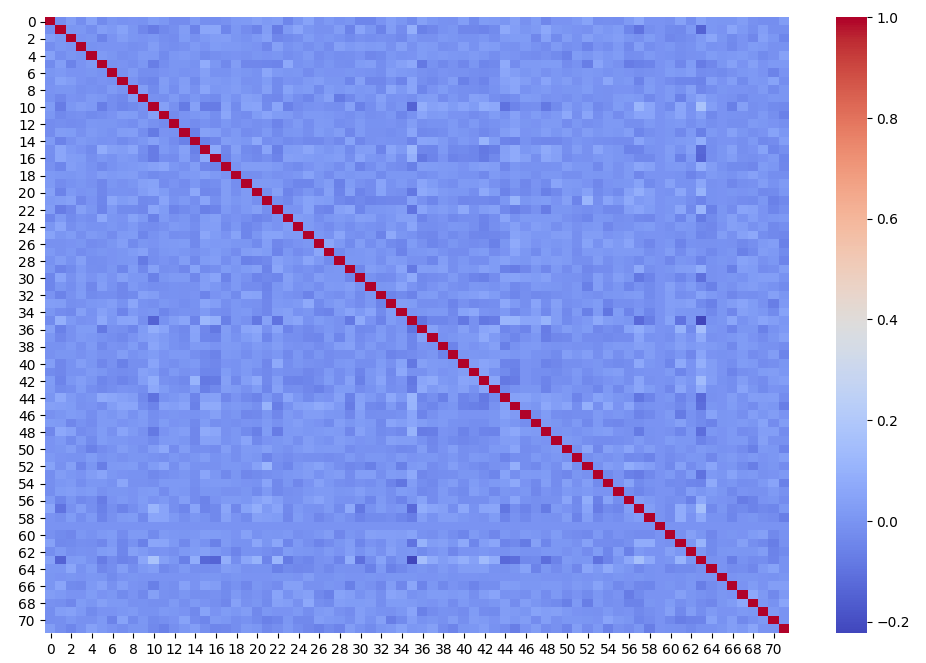

Линейной корреляции между признаками не отмечено.

## Исследование кластеризации

На вэбинарах были озвучены следующие основные методы кластеризации:
- метод K-Means
- метод DBSCAN
- иерархический алгоритм кластеризации
- графовые методы

И методы оценки кластеризации:
- "метод локтя"
- индекс Дэвиса-Болдина
- метод силуэта
- индекс Хопкинса
- метрики Среднее внутрикластерное расстояние, Среднее межкластерное расстояние, Гомогенность, Полнота, V-мера, коэффициент силуэта

### Метод K-Means и Mini-batch K-Means

In [119]:
import time

from time import time
from sklearn.cluster import (KMeans, MiniBatchKMeans)
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


Для модели K-Means в качестве метрики часто применяется "мето локтя". Необходимо несколько рах прогнать модель с разными количествами кластеров, собрать значения "инерции", и построить график. В точке излома будет находится оптимальное количество кластеров.

In [120]:
# скалирум наши данные, это важно для модели k-means

scaler = StandardScaler()

scaled_base_small = scaler.fit_transform(base_small)

In [156]:
#km_scores= []
#for i in range(400, 4000, 400):
#    km = KMeans(init="k-means++", n_clusters=i, random_state=0).fit(scaled_base_small)
#    preds = km.predict(scaled_base_small)
    
#    print("Score for number of cluster(s) {}: {}".format(i,km.score(scaled_base_small)))
#    km_scores.append(-km.score(scaled_base_small))

Score for number of cluster(s) 400: -10972238.74937079
Score for number of cluster(s) 800: -10068874.267563041
Score for number of cluster(s) 1200: -9541147.812428312
Score for number of cluster(s) 1600: -9176019.782576554
Score for number of cluster(s) 2000: -8897857.374224031
Score for number of cluster(s) 2400: -8665466.7355869
Score for number of cluster(s) 2800: -8478318.873034991
Score for number of cluster(s) 3200: -8309906.173187698
Score for number of cluster(s) 3600: -8153969.282995354


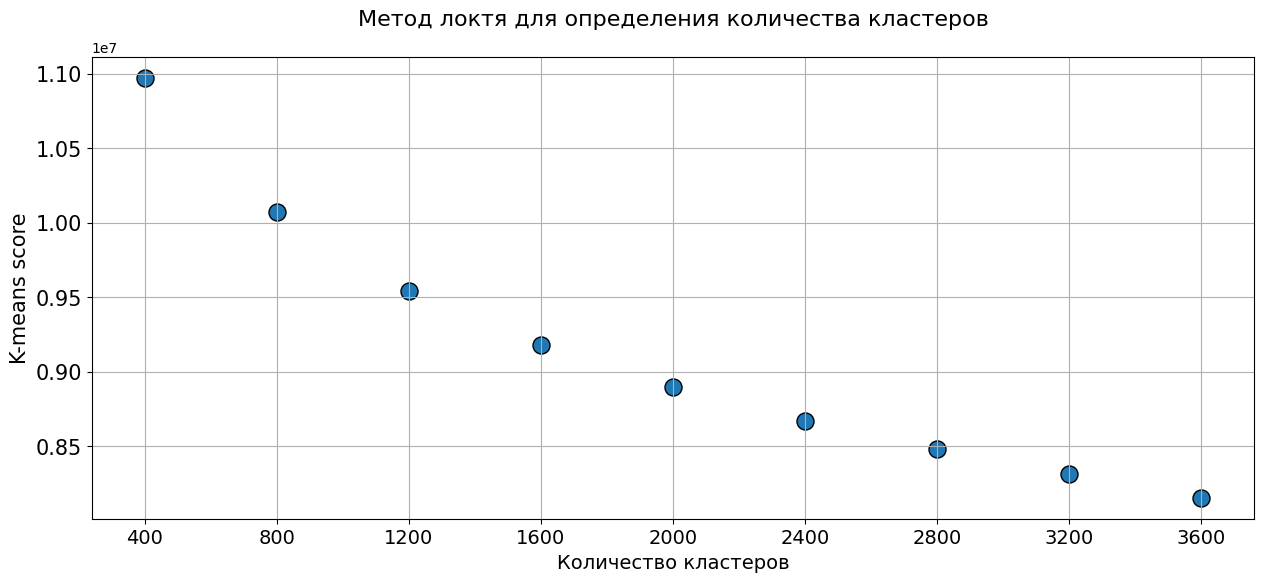

In [157]:
#plt.figure(figsize=(15,6))
#plt.title("Метод локтя для определения количества кластеров\n",fontsize=16)
#plt.scatter(x=[i for i in range(400, 4000, 400)],y=km_scores,s=150,edgecolor='k')
#plt.grid(True)
#plt.xlabel("Количество кластеров",fontsize=14)
#plt.ylabel("K-means score",fontsize=15)
#plt.xticks([i for i in range(400, 4000, 400)],fontsize=14)
#plt.yticks(fontsize=15)
#plt.show()

Можно оценить "локоть" в величину 2000 кластеров.

Сохраняю для скорости перепроведения тетради:
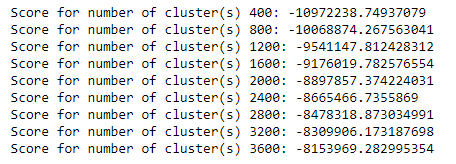
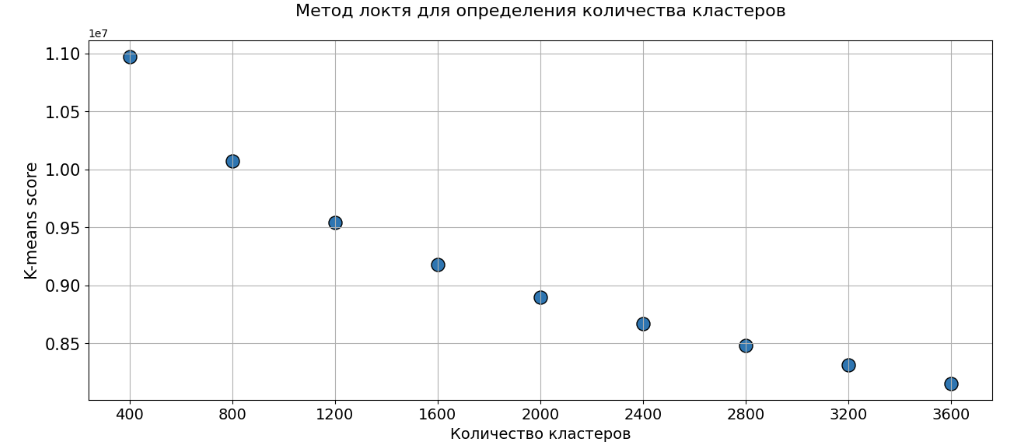

In [158]:
# инициализиуем лучшую модель k-means

k_means = KMeans(init="k-means++", n_clusters=2000, random_state=0)
start0 = time()
k_means.fit(scaled_base_small)
end0 = time()
t_k_means = (end0 - start0) / 60
t_k_means

2.006347684065501

In [160]:
# зафиксируем метки кластеров

labels_km = k_means.labels_

In [164]:
# рассчитаем коэффициент силуэта

#sil_km = metrics.silhouette_score(scaled_base_small, labels_km, metric='euclidean')
#print("Коэффициент силуэта:", sil_km)

Коэффициент силуэта: 0.06148499970670254


Тоже очень долго считает:
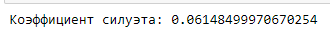

In [163]:
db_km = metrics.davies_bouldin_score(scaled_base_small, labels_km)
print("Индекс Дэвиса-Боулдина:", db_km)

ch_km = metrics.calinski_harabasz_score(scaled_base_small, labels_km)
print("Индекс Калински-Харабаша:", ch_km)

Индекс Дэвиса-Боулдина: 3.00405785592755
Индекс Калински-Харабаша: 154.9988398839959


Описание работы **коэффициента силуэта**:
- Оценка ограничена от -1 за неправильную кластеризацию до +1 за высокоплотную кластеризацию. Баллы около нуля указывают на перекрывающиеся кластеры.
- Оценка выше, когда кластеры плотные и хорошо разделенные, что относится к стандартной концепции кластера.

Описание **индекса Калински-Харабаша**:
- Индекс представляет собой отношение суммы дисперсии между кластерами и дисперсии внутри кластера для всех кластеров (где дисперсия определяется как сумма квадратов расстояний)
- Оценка выше, когда кластеры плотные и хорошо разделены, что соответствует стандартной концепции кластера.

Описание **индекса Дэвиса-Боулдина**:
- Этот индекс показывает среднее «сходство» между кластерами, где сходство — это мера, сравнивающая расстояние между кластерами с размером самих кластеров.
- Ноль — это наименьшая возможная оценка. Значения, близкие к нулю, указывают на лучшее разбиение.

Попробуем теперь произвести расчеты с помощью метода **Mini-Batches K_Means**.

In [146]:
# произведем поиск по количеству кластеров

#mbk_scores= []
#for i in range(250, 5250, 250):
#    mini_bk = MiniBatchKMeans(init="k-means++", n_clusters=i, max_no_improvement=10,
#                                verbose=0, random_state=0).fit(scaled_base_small)
#    preds_m = mini_bk.predict(scaled_base_small)
    
#    print("Score for number of cluster(s) {}: {}".format(i,mini_bk.score(scaled_base_small)))
#    mbk_scores.append(-mini_bk.score(scaled_base_small))

Score for number of cluster(s) 250: -11942074.896532755
Score for number of cluster(s) 500: -10927049.42275306
Score for number of cluster(s) 750: -10432548.634369519
Score for number of cluster(s) 1000: -10127144.904527605
Score for number of cluster(s) 1250: -9845350.843300987
Score for number of cluster(s) 1500: -9643771.383553248
Score for number of cluster(s) 1750: -9467769.659121554
Score for number of cluster(s) 2000: -9308229.832971273
Score for number of cluster(s) 2250: -9200976.012426766
Score for number of cluster(s) 2500: -9081753.854256745
Score for number of cluster(s) 2750: -8945529.186835557
Score for number of cluster(s) 3000: -8847445.079890061
Score for number of cluster(s) 3250: -8712299.359030303
Score for number of cluster(s) 3500: -8673948.551872678
Score for number of cluster(s) 3750: -8544798.16566081
Score for number of cluster(s) 4000: -8537996.563153265
Score for number of cluster(s) 4250: -8446464.4902237
Score for number of cluster(s) 4500: -8358621.87399

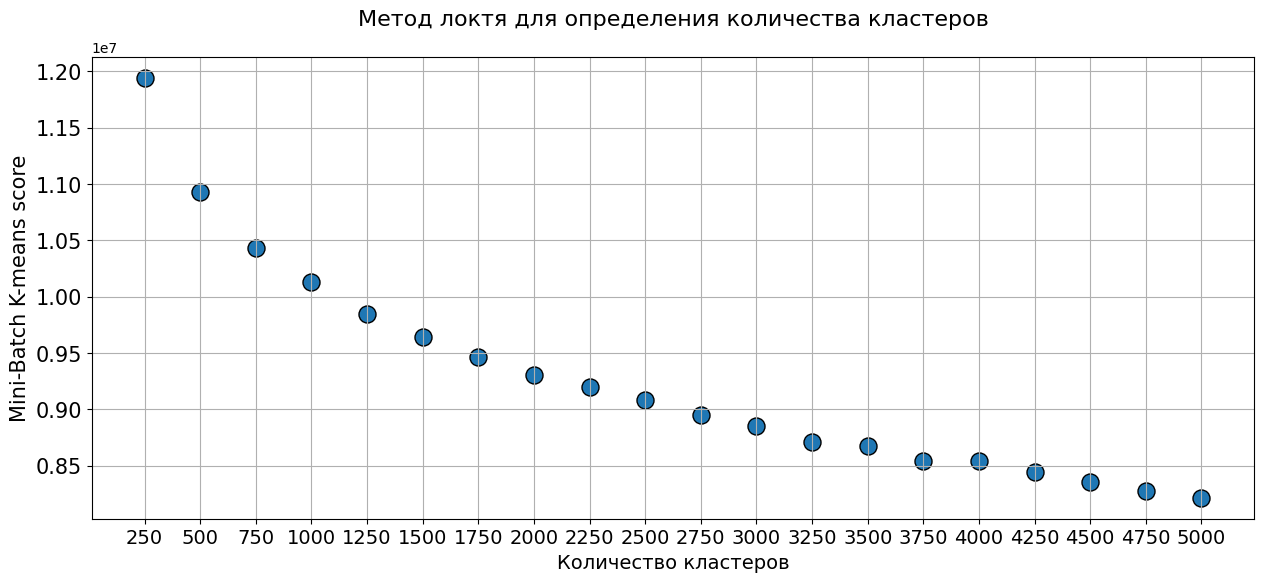

In [149]:
#plt.figure(figsize=(15,6))
#plt.title("Метод локтя для определения количества кластеров\n",fontsize=16)
#plt.scatter(x=[i for i in range(250, 5250, 250)],y=mbk_scores,s=150,edgecolor='k')
#plt.grid(True)
#plt.xlabel("Количество кластеров",fontsize=14)
#plt.ylabel("Mini-Batch K-means score",fontsize=15)
#plt.xticks([i for i in range(250, 5250, 250)],fontsize=14)
#plt.yticks(fontsize=15)
#plt.show()

Пожалуй, и в этом методе точка перегиба находится где-то в области 3000 кластеров.

Сохраняю для скорости перезапуска тетради:
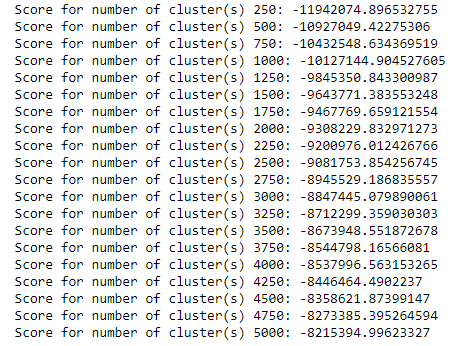
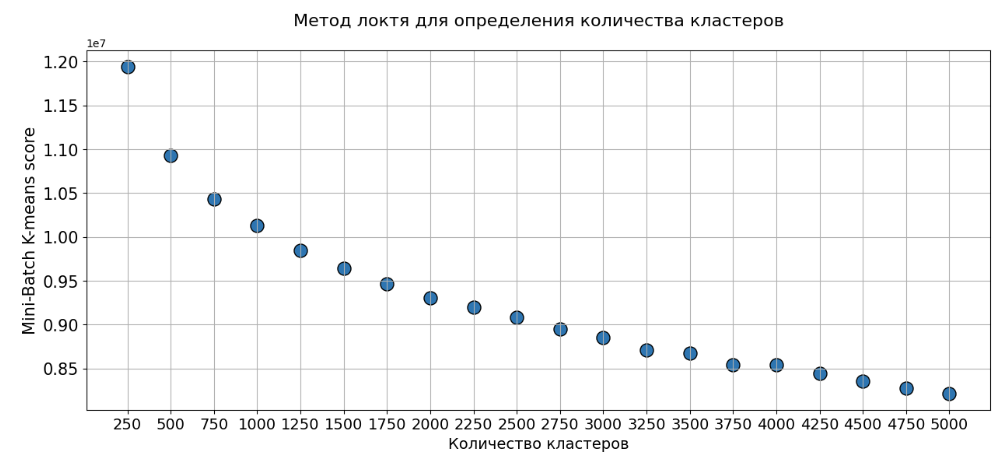

In [153]:
# инициализируем модель мини-батчей

mbk = MiniBatchKMeans(init="k-means++",n_clusters=3000, max_no_improvement=10, verbose=0, random_state=0)

start1 = time()

mbk.fit(scaled_base_small)

end1 = time()
t_mini_batch = (end1 - start1) / 60
t_mini_batch

0.16405582825342815

In [ ]:
# зафиксируем метки кластеров

labels_mbk = mbk.labels_

In [154]:
# рассчитаем коэффициент силуэта

#sil_mbk = metrics.silhouette_score(scaled_base_small, labels_mbk, metric='euclidean')
#print("Коэффициент силуэта:", sil_mbk)

0.019706806746633918

Зафиксирую, так как долгий расчет
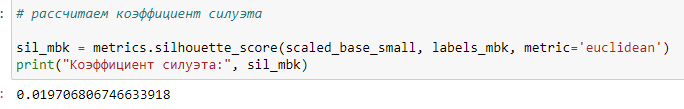

In [165]:
db_mbk = metrics.davies_bouldin_score(scaled_base_small, labels_mbk)
print("Индекс Дэвиса-Боулдина:", db_mbk)

ch_mbk = metrics.calinski_harabasz_score(scaled_base_small, labels_mbk)
print("Индекс Калински-Харабаша:", ch_mbk)

Индекс Дэвиса-Боулдина: 2.581122665702157
Индекс Калински-Харабаша: 106.08203323575387


Величина коэффициента силуэта в три раза ниже, чем у модели K-Means, и все еще лежит в области околонулевых значений. Величины других коэффициентов чуть ниже по сравнению с методом K-Means.

### Метод DBSCAN

Метод, по описанию, является более требовательным к памяти при расчетах, нежели метод K-Means. Как можно сразу оптимизировать процесс?  В описании метода предлагают использовать кластеризацию OPTICS в сочетании с extract_dbscan методом. Или сжать данные, используя BIRCH.

In [166]:
from sklearn.cluster import DBSCAN

In [182]:
#for samples in range(2, 10, 2):
#    for ep in range(2, 8, 1):
#        dbs = DBSCAN(eps=ep/10, min_samples=samples).fit(scaled_base_small)
#        labs = dbs.labels_
#        metr = metrics.davies_bouldin_score(scaled_base_small, labs)
#        n_clust = len(set(labs))
#        print("Score for number of cluster(s):", samples, ep, metr, n_clust)

Score for number of cluster(s): 2 2 1.1019632007228684 4498
Score for number of cluster(s): 2 3 1.1120592680151755 4762
Score for number of cluster(s): 2 4 1.1198156766930625 4962
Score for number of cluster(s): 2 5 1.1198674795521377 5087
Score for number of cluster(s): 2 6 1.1215694032016357 5294
Score for number of cluster(s): 2 7 1.1235301032894125 5522
Score for number of cluster(s): 4 2 1.1190153672756118 739
Score for number of cluster(s): 4 3 1.140260964869309 877
Score for number of cluster(s): 4 4 1.1657146753209784 966
Score for number of cluster(s): 4 5 1.1777947762125651 1007
Score for number of cluster(s): 4 6 1.1874010901318957 1071
Score for number of cluster(s): 4 7 1.196415446271383 1125
Score for number of cluster(s): 6 2 1.1348263015573743 275
Score for number of cluster(s): 6 3 1.1492603897755382 357
Score for number of cluster(s): 6 4 1.1724180200616974 444
Score for number of cluster(s): 6 5 1.1892684562179878 491
Score for number of cluster(s): 6 6 1.20328240638

Сохраняю для скорости перезапуска тетради:
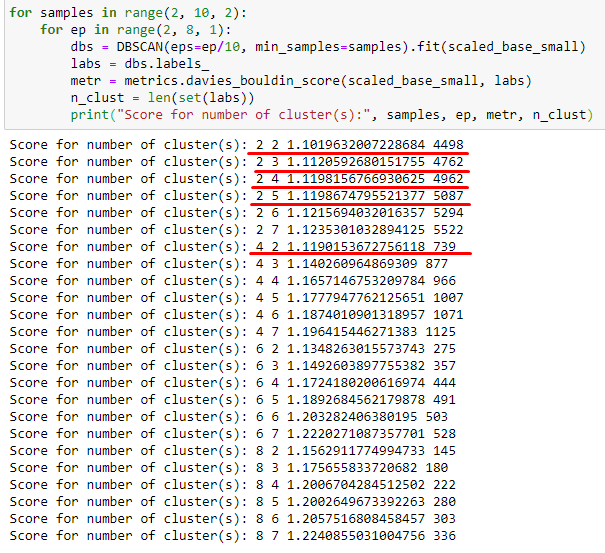

Еслил ориентироваться на значение индекса Дэвиса-Боулдина, то чем ближе значение индекса к нулю, тем лучше сформировалис кластеры. Наилучшие значения метрики получились в случаях:
- минимальное количество образцов вокруг кластера - 2, с расстоянием вокруг образца от 0,2 до 0,5;
- и минимальное количество образцов вокруг кластера - 4, с расстояние вокруг образца 0,2.

При этом, в случае минимум 4 соседей для кластера количество этих кластеров определено как 739. А если соседей будет только 2, то кластеров получается от 4500 до 5100 штук.

In [189]:
# иницируем лучшую модель

dbscan = DBSCAN(eps=0.2, min_samples=4)

start2 = time()

dbscan.fit(scaled_base_small)

end2 = time()
t_dbscan = (end2 - start2) / 60
t_dbscan

0.6879944324493408

In [190]:
# зафиксируем метки кластеров

labels_dbscan = dbscan.labels_

In [191]:
# количество сформированных кластеров

n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_clusters_

738

In [192]:
# рассчитаем индексы

db_dbscan = metrics.davies_bouldin_score(scaled_base_small, labels_dbscan)
print("Индекс Дэвиса-Боулдина:", db_dbscan)

ch_dbscan = metrics.calinski_harabasz_score(scaled_base_small, labels_dbscan)
print("Индекс Калински-Харабаша:", ch_dbscan)

Индекс Дэвиса-Боулдина: 1.1190153672756118
Индекс Калински-Харабаша: 7.651764887969215


In [193]:
# рассчитаем коэффициент силуэта

#sil_dbscan = metrics.silhouette_score(scaled_base_small, labels_dbscan, metric='euclidean')
#print("Коэффициент силуэта:", sil_dbscan)

Коэффициент силуэта: -0.2623656072414096


Долгий расчет.
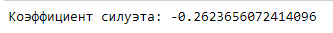
ОТрицательное значение указывает на неверную кластеризацию.

Несмотря на описание метода, модель обработала данные весьма быстро. Не пришлось использовать другие модификации методики.

### Иерархическая кластеризация

Неприменима при таком объеме входящих данных.

Попробовала через FeatureAgglomeration, но не поняла ее смысла. Количество кластеров меньше или равно количеству параметров данных. Что дальше с этим делать - неясно.

### Выбор метода кластеризации

Получается, что удалось рассмотреть 4 методики, и наилучшей кажется методика Mini-Batch K-Means. Она быстрее рассчитывается, обладает неплохими значениями использованных метрик. 

In [210]:
scaled_base_large = scaler.fit_transform(base_large)

start3 = time()

mbk.fit(scaled_base_large)

end3 = time()
t_mini_batch_l = (end3 - start3) / 60
t_mini_batch_l

1.1598051508267722

## Поиск соответствий

### Поиск соответствий на малом датафрейме с помощью FAISS

In [45]:
#dims = df_base_small.shape[1]
#n_cells = 20
#quantizer = faiss.IndexFlatL2(dims)
#idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [46]:
#idx_l2.train(np.ascontiguousarray(df_base_small.values).astype('float32'))
#idx_l2.add(np.ascontiguousarray(df_base_small.values).astype('float32'))

AssertionError: 

In [ ]:
#base_index = {k: v for k, v in enumerate(df_base_small.index.to_list())}

In [ ]:
#targets = df_train_small["Target"]
#df_train_small.drop("Target", axis=1, inplace=True)

In [ ]:
#candidate_number = 5
#r, idx = idx_l2.search(np.ascontiguousarray(df_train_small.values).astype('float32'), candidate_number)